# Data Analysis of Prices

### Polars Preprocessing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

# These commands enlarge the column size of the dataframe so things like 0x... are not truncated
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
# load parquet file into polars dataframe polars dataframe
cow_uni_chain_outer_pl = pl.read_parquet('data/cow_uni_chain_outer_pl_historical.parquet')

In [3]:
cow_uni_chain_outer_pl.shape

(527322, 23)

In [4]:
cow_uni_chain_outer_pl.columns

['trades_timestamp',
 'swaps_blockNumber',
 'trades_txHash',
 'trades_feeAmount',
 'trades_sellToken_id',
 'trades_buyToken_id',
 'trades_sellAmount_converted',
 'trades_buyAmount_converted',
 'name',
 'environment',
 'swaps_pool_id',
 'swaps_tokenIn_id',
 'swaps_tokenOut_id',
 'swaps_amountIn_converted',
 'swaps_amountOut_converted',
 'transaction_gas_fee_one_hop',
 'transaction_gas_fee_median',
 'trades_buy_sell_ratio',
 'trades_sell_buy_ratio',
 'swaps_amountIn_amountOut_ratio',
 'swaps_amountOut_amountIn_ratio',
 'prices_assetPair_id',
 'prices_price']

In [5]:
# sort by transaction_gas_fee_median
cow_uni_chain_outer_pl.sort('transaction_gas_fee_median', reverse=True).head(5)

trades_timestamp,swaps_blockNumber,trades_txHash,trades_feeAmount,trades_sellToken_id,trades_buyToken_id,trades_sellAmount_converted,trades_buyAmount_converted,name,environment,swaps_pool_id,swaps_tokenIn_id,swaps_tokenOut_id,swaps_amountIn_converted,swaps_amountOut_converted,transaction_gas_fee_one_hop,transaction_gas_fee_median,trades_buy_sell_ratio,trades_sell_buy_ratio,swaps_amountIn_amountOut_ratio,swaps_amountOut_amountIn_ratio,prices_assetPair_id,prices_price
i64,i64,str,i64,str,str,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
1655526233,14983045,null,null,null,null,null,null,null,null,"""USDC_WETH .3%""","""WETH""","""USDC""",383.237054,410968.660943,5.432645,13.355686,null,null,0.000933,1072.361497,null,null
1672802939,16330739,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""USDC""","""WETH""",422800.663946,338.644914,5.294724,13.016621,null,null,1248.50735,0.000801,null,null
1655539351,14983888,null,null,null,null,null,null,null,null,"""USDC_WETH .05%...","""USDC""","""WETH""",655581.489278,669.173454,4.773773,11.735907,null,null,979.688428,0.001021,null,null
1655005971,14948045,null,null,null,null,null,null,null,null,"""USDC_WETH .3%""","""USDC""","""WETH""",1.0524e6,728.45687,3.893746,9.572438,null,null,1444.721964,0.000692,null,null
1635361917,13501168,null,null,null,null,null,null,null,null,"""USDC_WETH .3%""","""USDC""","""WETH""",1.7270e6,437.218886,3.729749,9.169265,null,null,3950.063915,0.000253,null,null


In [6]:
# return the larger value between trades_buy_sell_ratio and trades_sell_buy_ratio in a lambda function. This serves as a column equalization function for trades_buy_sell_ratio and trades_sell_buy_ratio
execution_prices_pl = cow_uni_chain_outer_pl.with_columns([
    (pl.col("trades_buy_sell_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_buy_sell_ratio'),
    (pl.col("trades_sell_buy_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_sell_buy_ratio'),
    (pl.col("swaps_amountIn_amountOut_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountIn_amountOut_ratio'),
    (pl.col("swaps_amountOut_amountIn_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountOut_amountIn_ratio'),
])

In [7]:
# add columns that tell us the trade directionality for the trades and swaps. 
# we label the trade direction WETH -> USDC when WETH is in the CoW buy column and the UniV3 amountOut column. 
# Conversely, the USDC -> WETH direction is when USDC is in the CoW sell column and the Univ3 amountIn column.
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buyToken_id").apply(lambda x: True if x == 'WETH' else False)).alias('trades_buy_WETH'),
    (pl.col("swaps_tokenOut_id").apply(lambda x: True if x == 'WETH' else False)).alias('swaps_buy_WETH'),
])

In [8]:
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buy_WETH") & pl.col("swaps_buy_WETH")).alias('buy_WETH'), # buy WETH
    (~pl.col("trades_buy_WETH") & ~pl.col("swaps_buy_WETH")).alias('sell_WETH'), # sell WETH
])


### Pandas Preprocessing

In [9]:
# convert execution_prices_pl to pandas dataframe for easier plotting.
execution_prices_pd = execution_prices_pl.to_pandas()

# set trades_timestamp as index and order by trades_timestamp
execution_prices_pd = execution_prices_pd.set_index('trades_timestamp').sort_index()

# create a new dataframe with a unique integer index. make the current timestamp index a column
reindexed_df = execution_prices_pd.reset_index()

In [10]:
reindexed_price_df = reindexed_df[[
    'trades_timestamp',                     # timestamp
    'trades_sell_buy_ratio',                # cow price
    'swaps_amountOut_amountIn_ratio',       # univ3 price
    'prices_price',                         # chain price
    'transaction_gas_fee_one_hop',          # univ3 single hop swap
    'transaction_gas_fee_median',           # univ3 median swap transaction cost
    'buy_WETH'                              # trade direction.
    ]]

# rename columns
reindexed_price_df.columns = [
    'timestamp',                            # timestamp
    'cow_price',                            # cow price
    'univ3_price',                          # univ3 price
    'chain_price',                          # chain price
    'transaction_gas_fee_one_hop',          # univ3 single hop swap
    'transaction_gas_fee_median',           # univ3 median swap transaction cost
    'buy_WETH'                              # trade direction.
]

In [11]:
# forward fill reindexed_price_df
reindexed_price_df = reindexed_price_df.fillna(method='ffill')

In [12]:
# convert transaction_gas_fee into usd amount
reindexed_price_df['transaction_gas_fee_one_hop_usd'] = reindexed_price_df['transaction_gas_fee_one_hop'] * reindexed_price_df['univ3_price']
reindexed_price_df['transaction_gas_fee_median_usd'] = reindexed_price_df['transaction_gas_fee_median'] * reindexed_price_df['univ3_price']

In [13]:
# filter trade directions
buy_WETH_df = reindexed_price_df[reindexed_price_df['buy_WETH'] == True]
sell_WETH_df = reindexed_price_df[reindexed_price_df['buy_WETH'] == False]

In [14]:
# filter for outliers if transaction_gas_fee_one_hop_usd > $100 usd value. Outliers exist because the median value is an imperfect heuristic.
# the median value skews the outliers. More details in the report
buy_WETH_df = buy_WETH_df[buy_WETH_df['transaction_gas_fee_median_usd'] < 100]
sell_WETH_df = sell_WETH_df[sell_WETH_df['transaction_gas_fee_median_usd'] < 100]

In [15]:
# single hop gas adjusted prices
buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_WETH_df.loc[:, 'univ3_price'] + buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_WETH_df.loc[:, 'univ3_price'] - sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']

# add new price values that add the gas cost
buy_WETH_df.loc[:, 'univ3_gas_median_price'] = buy_WETH_df.loc[:, 'univ3_price'] + buy_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
sell_WETH_df.loc[:, 'univ3_gas_median_price'] = sell_WETH_df.loc[:, 'univ3_price'] - sell_WETH_df.loc[:, 'transaction_gas_fee_median_usd']

In [16]:
# convert index to datetime format
sell_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(sell_WETH_df.timestamp, utc=True, unit='s')
buy_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(buy_WETH_df.timestamp, utc=True, unit='s')

In [17]:
# define color scheme
cow_color = '#0000b3'
univ3_color = '#993366'
chain_color = '#004d00'

# define date filter
date_filter = '2023-03-01'

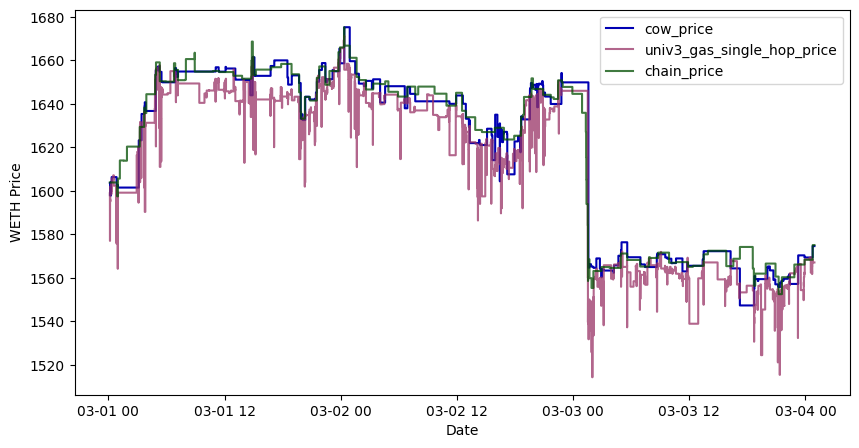

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
# plot prices on y axis and timestamp on x axis
fig1, ax = plt.subplots(figsize=(10, 5))
ax.step(
    sell_WETH_df['timestamp'].loc[sell_WETH_df['timestamp'] > date_filter], 
    sell_WETH_df['cow_price'].loc[sell_WETH_df['timestamp'] > date_filter], 
    label='cow_price',color=cow_color)
ax.step(
    sell_WETH_df['timestamp'].loc[sell_WETH_df['timestamp'] > date_filter], 
    sell_WETH_df['univ3_gas_single_hop_price'].loc[sell_WETH_df['timestamp'] > date_filter], 
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=0.75)
ax.step(
    sell_WETH_df['timestamp'].loc[sell_WETH_df['timestamp'] > date_filter], 
    sell_WETH_df['chain_price'].loc[sell_WETH_df['timestamp'] > date_filter], 
    label='chain_price', color=chain_color, alpha=0.75)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.show();

# save figure
fig1.savefig('../report/diagrams/weth_sell_line.eps', format='eps', bbox_inches='tight')
fig1.savefig('../report/diagrams/weth_sell_line.pdf', format='pdf', bbox_inches='tight')

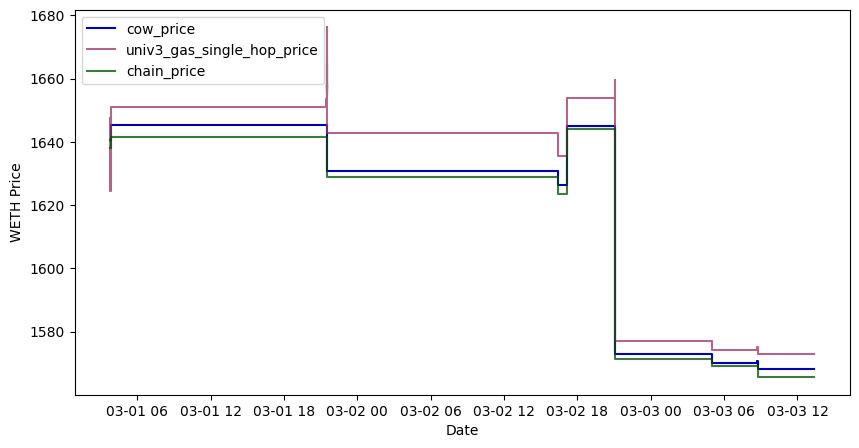

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [19]:
# plot prices on y axis and timestamp on x axis
fig2, ax = plt.subplots(figsize=(10, 5))
ax.step(
    buy_WETH_df['timestamp'].loc[buy_WETH_df['timestamp'] > date_filter], 
    buy_WETH_df['cow_price'].loc[buy_WETH_df['timestamp'] > date_filter], 
    label='cow_price',color=cow_color)
ax.step(
    buy_WETH_df['timestamp'].loc[buy_WETH_df['timestamp'] > date_filter], 
    buy_WETH_df['univ3_gas_single_hop_price'].loc[buy_WETH_df['timestamp'] > date_filter], 
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=0.75)
ax.step(
    buy_WETH_df['timestamp'].loc[buy_WETH_df['timestamp'] > date_filter], 
    buy_WETH_df['chain_price'].loc[buy_WETH_df['timestamp'] > date_filter], 
    label='chain_price', color=chain_color, alpha=0.75)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.show();

fig2.savefig('../report/diagrams/weth_buy_line.eps', format='eps', bbox_inches='tight')
fig2.savefig('../report/diagrams/weth_buy_line.pdf', format='pdf', bbox_inches='tight')

### Price Differences

In [20]:
# get the price price difference percent between cow and univ3 gas adjusted price in buy_WETH_df
buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (buy_WETH_df['cow_price'] - buy_WETH_df['univ3_gas_single_hop_price']) / buy_WETH_df['cow_price'] * 100
buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (buy_WETH_df['cow_price'] - buy_WETH_df['univ3_gas_median_price']) / buy_WETH_df['cow_price'] * 100

In [21]:
# get the price price difference percent between cow and univ3 gas adjusted price in sell_WETH_df
sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (sell_WETH_df['cow_price'] - sell_WETH_df['univ3_gas_single_hop_price']) / sell_WETH_df['cow_price'] * 100
sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (sell_WETH_df['cow_price'] - sell_WETH_df['univ3_gas_median_price']) / sell_WETH_df['cow_price'] * 100

In [22]:
# calculate mean deviation between cow and chain prices for each row
sell_WETH_df['cow_chain_price_diff_percent'] = (sell_WETH_df['chain_price'] - sell_WETH_df['cow_price']) / sell_WETH_df['cow_price'] * 100
buy_WETH_df['cow_chain_price_diff_percent'] = (buy_WETH_df['chain_price'] - buy_WETH_df['cow_price']) / buy_WETH_df['cow_price'] * 100

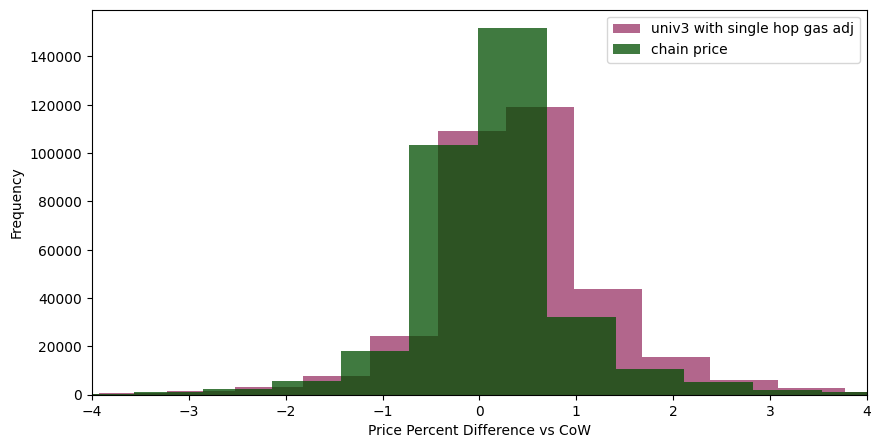

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [29]:
# plot histogram of the price diffs
fig3, ax = plt.subplots(figsize=(10, 5))
ax.hist(
    sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'],
    bins=100,
    label='univ3 with single hop gas adj',
    color=univ3_color,
    alpha=0.75)
ax.hist(
    sell_WETH_df['cow_chain_price_diff_percent'],
    bins=100,
    label='chain price',
    color=chain_color,
    alpha=0.75)

ax.set_xlim(-4, 4)
plt.xlabel('Price Percent Difference vs CoW')
plt.ylabel('Frequency')
plt.legend()
plt.show();

#save as eps
fig3.savefig('../report/diagrams/weth_sell_hist.eps', format='eps', bbox_inches='tight')
fig3.savefig('../report/diagrams/weth_sell_hist.pdf', format='pdf', bbox_inches='tight')

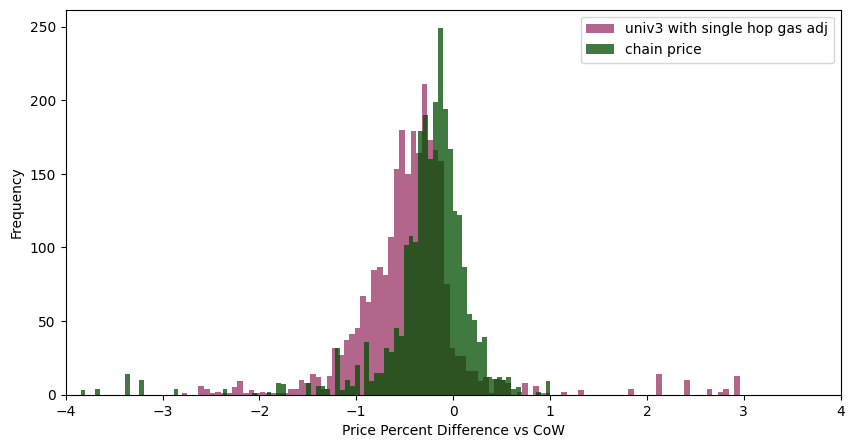

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [24]:
# plot histogram of the price diffs
fig3, ax = plt.subplots(figsize=(10, 5))
ax.hist(
    buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'],
    bins=100,
    label='univ3 with single hop gas adj',
    color=univ3_color,
    alpha=0.75)
ax.hist(
    buy_WETH_df['cow_chain_price_diff_percent'],
    bins=100,
    label='chain price',
    color=chain_color,
    alpha=0.75)

ax.set_xlim(-4, 4)
plt.xlabel('Price Percent Difference vs CoW')
plt.ylabel('Frequency')
plt.legend()
plt.show();

#save as eps
fig3.savefig('../report/diagrams/weth_buy_hist.eps', format='eps', bbox_inches='tight')
fig3.savefig('../report/diagrams/weth_buy_hist.pdf', format='pdf', bbox_inches='tight')

In [25]:
# get the dataframe of all values below the 90th percentile of cow_chain_price_diff_percent
sell_WETH_df_below_90th_percentile = sell_WETH_df.loc[sell_WETH_df['cow_chain_price_diff_percent'] < sell_WETH_df['cow_chain_price_diff_percent'].quantile(0.9)]
buy_WETH_df_below_90th_percentile = buy_WETH_df.loc[buy_WETH_df['cow_chain_price_diff_percent'] < buy_WETH_df['cow_chain_price_diff_percent'].quantile(0.9)]

In [26]:
# print the mean deviation of cow price from chainlink price with f strings
print(f"Mean deviation of cow sell price from chainlink price (90th percentile): {sell_WETH_df_below_90th_percentile['cow_chain_price_diff_percent'].mean():.2f}%")
print(f"Mean deviation of cow buy price from chainlink price (90th percentile): {buy_WETH_df_below_90th_percentile['cow_chain_price_diff_percent'].mean():.2f}%")

Mean deviation of cow sell price from chainlink price (90th percentile): -0.05%
Mean deviation of cow buy price from chainlink price (90th percentile): -0.36%


In [27]:
# statistics for buy_WETH_df single hop price difference
buy_WETH_df[['cow_univ3_gas_adj_price_diff_percent_single', 'cow_univ3_gas_adj_price_diff_percent_median']].describe()

,cow_univ3_gas_adj_price_diff_percent_single,cow_univ3_gas_adj_price_diff_percent_median
count,2633.000000,2633.000000
mean,-0.429835,-1.223915
std,0.603038,0.933262
min,-2.803140,-6.288586
25%,-0.680908,-1.703002
50%,-0.420337,-1.072460
75%,-0.216047,-0.635164
max,2.961507,1.962549


In [28]:
sell_WETH_df[['cow_univ3_gas_adj_price_diff_percent_single', 'cow_univ3_gas_adj_price_diff_percent_median']].describe()

,cow_univ3_gas_adj_price_diff_percent_single,cow_univ3_gas_adj_price_diff_percent_median
count,336575.000000,336575.000000
mean,0.428329,1.226751
std,1.040362,1.353130
min,-25.635191,-23.540488
25%,-0.001480,0.441705
50%,0.362156,0.980930
75%,0.850329,1.820892
max,44.396230,45.401712
